####Imports cell

In [1]:
# Object imports
import numpy as np
import pandas as pd
import torch

# Image handle imports
import cv2
from PIL import Image

# Data handle imports
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset

# Others
import random
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt
import os
import zipfile
import random
import io
import time
from pprint import pprint

In [2]:
# check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The file 'all_data_info.csv' is store all the information about the data we will on our Siamese model.
With Csv reader variable we could investigate the data, and from there decide how to build the model.

In [3]:
# CSV variable
all_data_csv = pd.read_csv('../Data/CSV/all_data_info.csv')
# Look at the first 20 images of the data
all_data_csv.head(20)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
6,Barnett Newman,NaN,abstract,7345.0,8640.0,6383948.0,wikiart,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II",train_only,True,62252.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg


In [4]:
total_num = len(all_data_csv)
train_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_only'])
test_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'test_only'])
train_and_test_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_and_test'])

artist_num = len(all_data_csv['artist'].unique())
genres_num = len(all_data_csv["genre"].dropna().unique())

pixelsx_mean = all_data_csv["pixelsx"].mean()
pixelsx_var = all_data_csv["pixelsx"].var()
pixelsx_max = int(all_data_csv["pixelsx"].max())
pixelsx_min = int(all_data_csv["pixelsx"].min())

pixelsy_mean = all_data_csv["pixelsy"].mean()
pixelsy_var = all_data_csv["pixelsy"].var()
pixelsy_max = int(all_data_csv["pixelsy"].max())
pixelsy_min = int(all_data_csv["pixelsy"].min())

average_paints_per_artist = all_data_csv['artist'].value_counts().mean()


#print(all_data_csv['artist'].value_counts())
# To check number of images with not NaN genre value
#Nan_genres_num = len(all_data_csv.loc[pd.isna(all_data_csv["genre"]) == False])

print(f'Total number of images in the data: {total_num}')
print(f'The Split of the data between Train only/Train and Test/ Test only is: {train_only_num}/{train_and_test_num}/{test_only_num}\n')

print(f'Number of different genres: {genres_num}')
print(f'Average paints per artist in this set: {average_paints_per_artist:.2f}\n')

print(f'The average size of X axis per image is {pixelsx_mean:.2f} pixel, and average size of Y axis per image is {pixelsy_mean:.2f}')
print(f'The highest (X, Y) measurements are ({pixelsx_max}, {pixelsy_max}), and the lowest are ({pixelsx_min}, {pixelsy_min})')
print(f'The variances of the axis measurements are ({pixelsx_var:.2f}, {pixelsy_var:.2f})')

Total number of images in the data: 103250
The Split of the data between Train only/Train and Test/ Test only is: 14164/86150/2936

Number of different genres: 42
Average paints per artist in this set: 44.52

The average size of X axis per image is 960.81 pixel, and average size of Y axis per image is 984.09
The highest (X, Y) measurements are (25528, 9541), and the lowest are (200, 162)
The variances of the axis measurements are (355538.29, 390799.19)


Presentation of random images from the dataset
Note: Not all the images are presented in their correct color format.

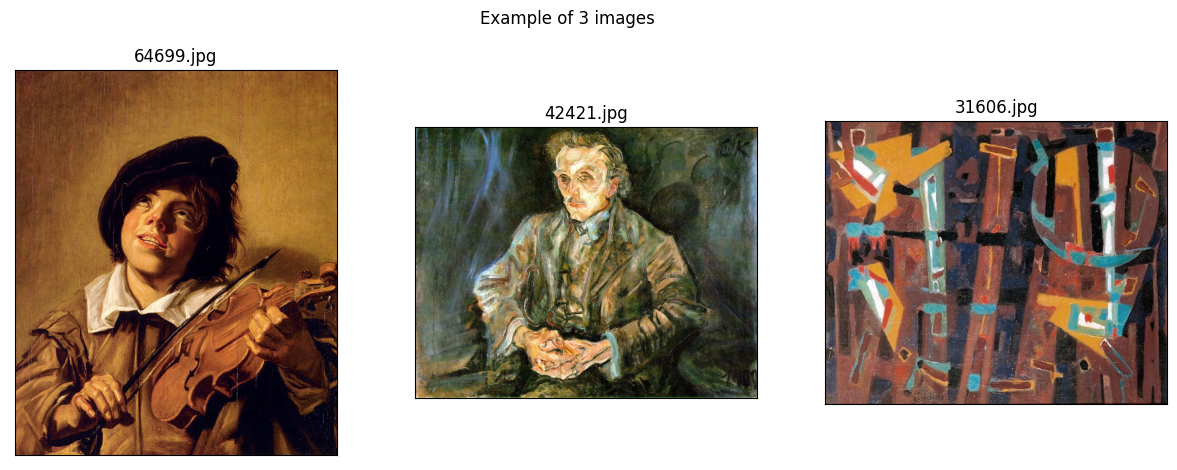

In [5]:
# Example:
img_folder_path = '../Data/Images/training/train'

plt.figure(figsize=(15,5))

for i in range(1,4):
    # choose a image file randomly from the training data
    random_image_name = random.choice(os.listdir(img_folder_path))

    # unzip image with color conversion
    archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
    image_data = archive.open("train/" + random_image_name)
    image = Image.open(image_data)

    # presenting the 3 images in a row
    plt.subplot(1, 3, i)
    plt.title(random_image_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.asarray(image))

plt.suptitle(f"Example of {3} images", y=1.001)
plt.show()

This cell I tried different ways to check how to present the image in the correct format color

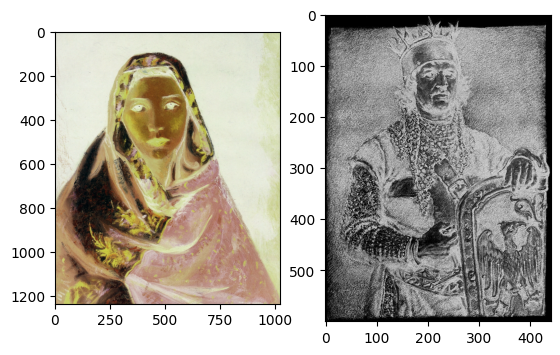

In [6]:
import imghdr
#image = cv2.imread('../Data/Images/training/train/95010.jpg')
#plt.imshow(image)
#plt.show()
try:
    for i in range(1):

        archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
        img_path = 'train/'
        #imgdata = archive.open(img_path+'75861.jpg')
        #print(imghdr.what("../Data/Images/training/train/"+'75861.jpg'))
        #print(img.getType())
        #image = Image.open(image_data)
        #print(image.format)
        image = cv2.imread("../Data/Images/training/train/"+"42790.jpg")
        image2 = cv2.imread("../Data/Images/training/train/"+"75861.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = 255 - image[:,:]
        image2 = 255 - image2[:,:]
        #print(imgdata)
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
    plt.show()
except Image.DecompressionBombError:
    print("error")
#try:
#    image = cv2.imread('../Data/Images/training/train/72255.jpg')
#    #plt.imshow(image)
#    #plt.show()
#except Image.DecompressionBombError:
#    print("error")

#### Data Loader

In [7]:

def resolution_fixture(path_from, path_to, file_name, new_res=256):
    images = []
    i1 = 0
    archive = zipfile.ZipFile(path_from + '/' + file_name + '.Zip', 'r')
    # first we extract all the filed im a given zip file, and store them in list of items in the form of [file_name, file_in bytes]
    for current_file_path in archive.namelist():
        if (i1) % 500 == 0:
            print(f"{i1} images processed")
        i1 += 1
        # separate the name
        if not "jpg" in current_file_path:
            continue
        else:
            image_name = current_file_path[len(file_name)+1:]

        try:

            file_object = io.BytesIO()
            image_data = archive.open(current_file_path)
            image = Image.open(image_data)
            tensor_image = transforms.Compose([transforms.ToTensor(), transforms.Resize((new_res, new_res))])(image)
            image = transforms.ToPILImage()(tensor_image)
            # save in file object buffer
            image.save(file_object, 'PNG')
            image.close()
            images.append([image_name, file_object])

        except Image.DecompressionBombError:
                print(f"DecompressionBombError in file {image_name}")
        except Exception as e:
            print(f" Error received in image {image_name}")
            print(f" Error massage: {str(e)}")


    #zip_file_bytes_io = io.BytesIO()
    #zip_file = zipfile.ZipFile(path_to + '/' + file_name + '.zip', 'w')

    with zipfile.ZipFile(path_to + '/' + file_name + '_' + str(new_res) + '.zip', 'w') as zip_obj:
        for image_name, bytes_stream in images:
            zip_obj.writestr(file_name + '/' + image_name, bytes_stream.getvalue())


# change to True to run the code
if False:
    path_from = "../Data/Zips"
    path_to = "../Data/Zips/Fixed_Zips"
    file_name = "train_1"
    new_res = 512
    resolution_fixture(path_from, path_to, file_name, new_res)

First, We should classify our data by train and test data

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# if the data frame is not yet defined we can extract it from files if it is already stored there.
# if the data frame is not saved in files either, we will make it from start
if ("train_data_frame" not in globals()) and (not os.path.isfile("../Data/Variables/train_data_frame.pkl")):
    # We will Train our model only with artists with more than 10 paints in the storage
    paints_per_painter = all_data_csv['artist'].value_counts()
    #a =  all_data_csv.items()
    #paints_per_painter = all_data_csv.items()['artist'].value_counts()
    #print(paints_per_painter)
    actual_artist_list = [paints_per_painter.index[i] for i in range(len(paints_per_painter)) if paints_per_painter[i] > 10]

    # Here we are classifying the data by train and test paints as they registered in the CSV file
    # We take only the paints of the artist with more of 10 paints
    train_data_frame = pd.DataFrame({})
    test_data_frame = pd.DataFrame({})
    i1 = 0
    for artist in actual_artist_list:
        i1 += 1
        artist_data = all_data_csv[(all_data_csv['artist']==artist)]
        artist_train_data = artist_data.loc[(artist_data.in_train == True)]
        artist_test_data = artist_data.loc[(artist_data.in_train == False)]
        train_data_frame = pd.concat([train_data_frame, artist_train_data])
        test_data_frame = pd.concat([test_data_frame, artist_test_data])

    train_data_frame.to_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame.to_pickle("../Data/Variables/test_data_frame.pkl")

else:
    train_data_frame = pd.read_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame = pd.read_pickle("../Data/Variables/test_data_frame.pkl")

data loader class

In [9]:
class RootDataSet:
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.train_data_frame = train_data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if Fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"

            self.train_zip_name += '/'
        self.make_data_frame()


        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        if is_train:
            self.train_images_files = self.data_frame.iloc[:, 11].values
            self.train_labels = self.data_frame.iloc[:, 0].values
            self.train_index = self.data_frame.index.values

        self.choose_n_to_visualization(150, 15)

    def make_data_frame(self):
        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = train_data_frame.loc[train_data_frame['new_filename'].isin(image_name_list)]
        data_frame_count = self.data_frame["artist"].value_counts()
        self.data_frame = self.data_frame[self.data_frame['artist'].isin(data_frame_count[data_frame_count > 15].index) & self.data_frame['artist'].isin(data_frame_count[data_frame_count < 335].index)]
        self.data_frame = self.data_frame.reset_index(drop=True)


    def choose_n_to_visualization(self, n, num_artist=15):
        data_frame_count = self.data_frame["artist"].value_counts()[:num_artist]
        data_frame_vis = self.data_frame[self.data_frame['artist'].isin(data_frame_count.index)].reset_index(drop=True)
        train_index_vis = data_frame_vis.index.values
        train_labels_vis = data_frame_vis.iloc[:, 0].values

        indices = np.random.choice(train_index_vis, n)
        n_images = torch.empty((0, 3, self.res_size, self.res_size))
        labels = []
        for index in indices:
            file_name = self.train_images_files[index]
            image_data = self.train_archive.open(self.train_zip_name + file_name)
            image = Image.open(image_data)
            label = train_labels_vis[index]

            image = self.toTensor(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]
            image = self.normalize(image)

            n_images = torch.cat([n_images, torch.reshape(image, (1, 3, self.res_size, self.res_size))], 0)
            labels.append(label)
        self.n_images = n_images
        self.labels = labels


In [10]:
# An idea is to integrate the SingleDataSet and TripletDataSet with a root class
class SingleDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, train_data_frame, Fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three the image and the label
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            # transform the image to a specific dimension
            anchor_image = self.toTensor(anchor_image)

            # we will feed the model a 3 channel images.
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            anchor_image = self.normalize(anchor_image)

            return anchor_image, anchor_label

        # label = -1, is a signal to not forward the sample
        except Exception:
            print(f"could not load a file")
            return torch.empty(3, self.res_size, self.res_size), -1
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, self.res_size, self.res_size), -1


## to debug
#obj = SingleDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i % 1000 == 0:
#        print(f"done {i}")
#
#    i +=1



#nn_data = TripletDataSet("train_1", train_data_frame, 70000)

In [11]:
# inspiration from https://www.kaggle.com/code/spyrosrigas/20-painters-classification-with-cnns-and-svms
class TripletDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, train_data_frame, Fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        try:

            # extraction process of the three images per forward sample the 'triplet loss' is relies on
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
            positive_list = np.array(self.train_index[self.train_index!=index])
            positive_list = positive_list[bool_list]

            # case when in sub train group, item don't have a positive partner
            if(len(positive_list) == 0):
                raise Exception("No matching image for anchor")
            else:
                positive_index = random.choice(positive_list)

            positive_file_name = self.train_images_files[positive_index]
            positive_image_data = self.train_archive.open(self.train_zip_name + positive_file_name)
            positive_image = Image.open(positive_image_data)

            negative_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
            negative_index = random.choice(negative_list)
            negative_file_name = self.train_images_files[negative_index]
            negative_image_data = self.train_archive.open(self.train_zip_name + negative_file_name)
            negative_image = Image.open(negative_image_data)

            if self.train_labels[positive_index] != self.train_labels[index]:
                print("positive and anchor dont have the same label")

            if self.train_labels[negative_index] == self.train_labels[index]:
                print("negative and anchor have the same label")


            anchor_image = self.toTensor(anchor_image)
            positive_image = self.toTensor(positive_image)
            negative_image = self.toTensor(negative_image)

            # we will feed the model a 3 channel images.
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if positive_image.shape[0] == 1:
                positive_image = torch.cat([positive_image, positive_image, positive_image], 0)
            if positive_image.shape[0] == 4:
                positive_image = positive_image[0:3]

            if negative_image.shape[0] == 1:
                negative_image = torch.cat([negative_image, negative_image, negative_image], 0)
            if negative_image.shape[0] == 4:
                negative_image = negative_image[0:3]

            anchor_image = self.normalize(anchor_image)
            positive_image = self.normalize(positive_image)
            negative_image = self.normalize(negative_image)

            ret_tensor = torch.stack(([anchor_image, positive_image, negative_image]))
            return ret_tensor, anchor_label

        # label = -1, is a signal to not forward the sample
        except Exception as e:
            print(f"could not load a file")
            print(f"Error message: {e}")
            return torch.empty(3, 3, self.res_size, self.res_size), -1
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), -1


## to debug
#obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i == 100:
#        print("done")
#        break
#    i +=1




Tester of data loader speed test

In [12]:
if False:
    start_time = time.perf_counter()

    obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
    data_loader = DataLoader(obj, batch_size=32, num_workers=0, shuffle=True)
    i = 0
    for inputs, labels in data_loader:
        #print(inputs.shape)
        #print(labels)
        if i == 63:
            break
        i += 1
        if i % 10 == 0:
            print(f"done {i}")

    end_time = time.perf_counter()
    print(f"{end_time - start_time:0.2f} seconds")


Zip maker

In [13]:
class Network2(nn.Module):
    def __init__(self, int_dim=3, out_dim=10):
        super(Network2, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(int_dim, 32, 4),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 4),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 4),
            nn.ReLU(),
            nn.Conv2d(128, 128, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.BatchNorm1d(128*26*26),
            nn.Linear(128*26*26, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.feature_extractor(x)
        #print(x.shape)
        #x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [14]:
class Network(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(Network, self).__init__()
        self.criterion = TripletLoss()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, 6),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(128*28*28, 512),
            nn.PReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x



In [15]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin


    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)


    def predict(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        predictions = distance_positive < distance_negative
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses, predictions


    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()



In [16]:
def test_run(test_loader, model):
    attempts = 0
    successes = 0
    for step, (inputs, labels) in enumerate(test_loader):
        if ((step + 1) % 300 == 0):
            break
        anchor_img = inputs[:, 0, :, :, :]
        positive_img = inputs[:, 1, :, :, :]
        negative_img = inputs[:, 2, :, :, :]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss, prediction = model.criterion.predict(anchor_out, positive_out, negative_out)
        successes += sum(prediction.cpu()).item()
        attempts += prediction.cpu().shape[0]

    print(f"success rate: {(successes / attempts):0.2f}")
    #input("Press Enter to continue...")



#obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
#model = Network().to(device)
#test_run(data_loader, model)

3-d visualization cell

In [17]:
from sklearn.decomposition import PCA

def visualization_3d(model, data_loader_object):
    pca = PCA(n_components=3)
    batch_size = 2
    n_images = data_loader_object.n_images
    labels = data_loader_object.labels
    embedded_image_list = np.empty([0, 128])
    for i in range(0, int(len(n_images)/batch_size) - 1):
        x = torch.empty((0,3,256,256))
        for j in range(batch_size):
            x = torch.cat([x, n_images[i*batch_size+j].reshape(1,3,256,256)], 0)
        #x = torch.cat([n_images[i].reshape(1,3,256,256), n_images[i].reshape(1,3,256,256)], 0)
        embedded_image = model(x.to(device))
        embedded_image_list = np.append(embedded_image_list, embedded_image.cpu().detach().numpy(), 0)
    principalComponents = pca.fit_transform(embedded_image_list)


    principalDf =pd.DataFrame(data = principalComponents, columns = ['pc1',  'pc2', 'pc3'])
    labelDf = pd.DataFrame(labels)
    principalDf = pd.concat([principalDf,labelDf],axis = 1,join='inner', ignore_index=True)
    principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
    principalDf.columns = ["pc1", "pc2", "pc3", "label"]


    # Create 3D container
    ax = plt.axes(projection = '3d')
    # Visualize 3D scatter plot
    unique_labels = principalDf["label"].unique()
    name_to_int = {name: i for i, name in enumerate(set(unique_labels))}
    integers = [name_to_int[name] for name in unique_labels]
    labels_colors = [(i - min(integers))/(max(integers) - min(integers))*255 for i in integers]
    labels_colors_dict = dict(zip(unique_labels, labels_colors))
    name_lengths_list = [labels_colors_dict[labels] for labels in principalDf["label"]]
    ax.scatter3D(principalDf["pc1"], principalDf["pc2"], principalDf["pc3"], c = name_lengths_list, cmap='gist_rainbow')
    # Give labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()


# for debug
if False:
    model = Network().to(device)
    triplet_obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
    for i in range(5):
        visualization_3d(model, triplet_obj)

In [18]:
def get_embeddings(model, inputs, out_dim):
    inputs = inputs.to(device)
    embeddings = torch.empty(0, out_dim)
    for i in range(len(inputs)):
        embeddings = torch.cat([embeddings, model(inputs[i].to(device))], 0)
    return embeddings

def _pairwise_distances(embeddings):

    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = torch.matmul(embeddings, embeddings.t())
    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)
    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = torch.unsqueeze(square_norm, 0) - 2.0 * dot_product + torch.unsqueeze(square_norm, 1)
    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.clamp(distances, min=0.0)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    mask = torch.empty(0, len(labels))
    for i in range(len(labels)):
        bool_list = torch.tensor([[label == labels[i] for label in labels]])
        mask = torch.cat([mask, bool_list])
    return mask

def _get_anchor_negative_triplet_mask(labels):
    mask = torch.empty(0, len(labels))
    for i in range(len(labels)):
        bool_list = torch.tensor([[label != labels[i] for label in labels]])
        mask = torch.cat([mask, bool_list])
    return mask

def batch_hard_triplet_loss(labels, embeddings, margin):

    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = mask_anchor_positive.to(torch.float32)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = mask_anchor_positive.to(device) * pairwise_dist

    # shape (batch_size, 1)
    hardest_positive_dist, _ = torch.max(anchor_positive_dist, dim=1, keepdim=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = mask_anchor_negative.to(torch.float32)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative.to(device))

    # shape (batch_size,)
    hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = torch.relu(hardest_positive_dist - hardest_negative_dist + margin)

    # Get final mean triplet loss
    triplet_loss = torch.mean(triplet_loss)

    return triplet_loss

## to debug
#batch_size = 8
#epochs = 1500
#model = Network().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
#obj = SingleDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
#triplet_obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#triplet_loader = DataLoader(triplet_obj, batch_size=batch_size, num_workers=0, shuffle=True)
#i = 0
#for epoch in range(epochs):
#
#    print(f"start epoch {epoch+1}")
#    print(optimizer.param_groups[0]['lr'])
#    running_loss = []
#    for step, (inputs, labels) in enumerate(data_loader):
#        optimizer.zero_grad()
#        if (step+1) % 200 == 0:
#            break
#        #if step == 0:
#        #    print(f'{labels[0]} {labels[1]}')
#        #if (step) % 10 == 0:
#        #    print(step)
#
#        to_continue = False
#        for i in range(len(labels)):
#            if labels[i] == -1:
#                to_continue=True
#        if to_continue:
#            continue
#        inputs = inputs.to(device)
#        embeddings = model(inputs)
#        loss = batch_hard_triplet_loss(labels, embeddings, 0.8)
#        loss.backward()
#        optimizer.step()
#        running_loss.append(loss.cpu().detach().numpy())
#
#
#    print("Epoch: {}/{} - Loss: {:.2f}".format(epoch+1, epochs, np.mean(running_loss)))
#    test_run(triplet_loader, model)
#    if epoch % 10 == 0:
#        visualization_3d(model, triplet_obj)
#    scheduler.step()






start epoch 1
0.001
49
99
149
199
249
299
Epoch: 1/240 - Loss: 4.63
success rate: 0.64


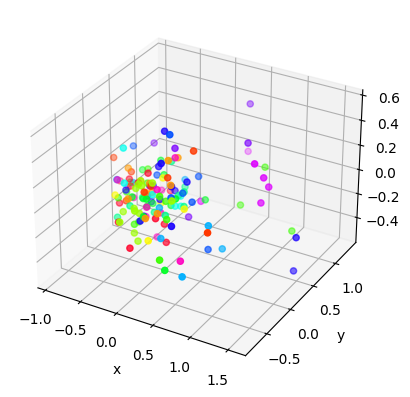

start epoch 2
0.001
49
99
149
199
249
299
Epoch: 2/240 - Loss: 0.42
success rate: 0.66


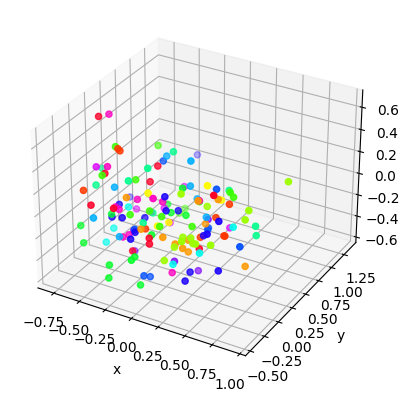

start epoch 3
0.001
49
99
149
199
249
299
Epoch: 3/240 - Loss: 0.40
success rate: 0.66


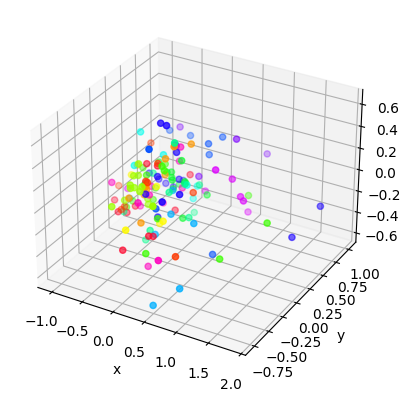

start epoch 4
0.001
49


In [ ]:

epochs=240
batch_size = 16
patience = 3
lr_steps = patience
min_loss = 100000000
hard_batch = False

model = Network().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
triplet_loss = TripletLoss().to(device)

if not hard_batch:
    train_loader_object = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
    train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
    test_loader_object = train_loader_object
    test_loader = train_loader
else:
    train_loader_object = SingleDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
    train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
    test_loader_object = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
    test_loader = DataLoader(test_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)


for epoch in range(epochs):

    print(f"start epoch {epoch+1}")
    print(optimizer.param_groups[0]['lr'])
    running_loss = []
    for step, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        #if (step+1) % 300 == 0:
        #    break
        if (step+1) % 50 == 0:
            print(step)

        to_continue = False
        for i in range(len(labels)):
            if labels[i] == -1:
                to_continue=True
        if to_continue:
            continue


        if not hard_batch:
            anchor_img = inputs[:,0,:,:,:].to(device)
            positive_img = inputs[:,1,:,:,:].to(device)
            negative_img = inputs[:,2,:,:,:].to(device)

            #anchor_img = anchor_img.to(device)
            #positive_img = positive_img.to(device)
            #negative_img = negative_img.to(device)

            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)

            loss = triplet_loss(anchor_out, positive_out, negative_out)

        else:
            inputs = inputs.to(device)
            embeddings = model(inputs)
            loss = batch_hard_triplet_loss(labels, embeddings, 0.8)

        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    current_loss = np.mean(running_loss)
    print("Epoch: {}/{} - Loss: {:.2f}".format(epoch+1, epochs, current_loss))
    test_run(test_loader, model)
    visualization_3d(model, test_loader_object)

    if current_loss < min_loss:
            min_loss = current_loss
            lr_steps = patience
    else:
        lr_steps = lr_steps - 1
        if lr_steps == 0:
            scheduler.step()
            lr_steps = patience

In [16]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_l
from sklearn.decomposition import PCA
import torch.nn.functional as F


def visualization_3d_(model, data_object):
    pca = PCA(n_components=3)
    batch_size = 2
    n_images = data_object.n_images
    labels = data_object.labels
    embedded_image_list = np.empty([0, 128])
    for i in range(0, int(len(n_images)/batch_size) - 1):
        x = torch.empty((0,3,256,256))
        for j in range(batch_size):
            x = torch.cat([x, n_images[i*batch_size+j].reshape(1,3,256,256)], 0)
        #x = torch.cat([n_images[i].reshape(1,3,256,256), n_images[i].reshape(1,3,256,256)], 0)
        embedded_image = model(x.to(device))
        embedded_image_list = np.append(embedded_image_list, embedded_image.cpu().detach().numpy(), 0)
    principalComponents = pca.fit_transform(embedded_image_list)


    principalDf =pd.DataFrame(data = principalComponents, columns = ['pc1',  'pc2', 'pc3'])
    labelDf = pd.DataFrame(labels)
    principalDf = pd.concat([principalDf,labelDf],axis = 1,join='inner', ignore_index=True)
    principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
    principalDf.columns = ["pc1", "pc2", "pc3", "label"]


    #fig = plt.figure(figsize=(9, 6))
    # Create 3D container
    ax = plt.axes(projection = '3d')
    # Visualize 3D scatter plot
    #mu = random.rand(100,1);
    unique_labels = principalDf["label"].unique()
    name_to_int = {name: i for i, name in enumerate(set(unique_labels))}
    integers = [name_to_int[name] for name in unique_labels]
    labels_colors = [(i - min(integers))/(max(integers) - min(integers))*255 for i in integers]
    labels_colors_dict = dict(zip(unique_labels, labels_colors))
    name_lengths_list = [labels_colors_dict[labels] for labels in principalDf["label"]]
    ax.scatter3D(principalDf["pc1"], principalDf["pc2"], principalDf["pc3"], c = name_lengths_list, cmap='gist_rainbow')
    # Give labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()



class TripletDataSet_(Dataset):
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.train_data_frame = train_data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if Fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"

            self.train_zip_name += '/'
        self.make_data_frame()


        #self.transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((res_size, res_size))])
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

        if is_train:
            self.train_images_files = self.data_frame.iloc[:, 11].values
            self.train_labels = self.data_frame.iloc[:, 0].values
            self.train_index = self.data_frame.index.values

        self.choose_n_to_visualization(150)

    def make_data_frame(self):
        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = train_data_frame.loc[train_data_frame['new_filename'].isin(image_name_list)]
        data_frame_count = self.data_frame["artist"].value_counts()[:3]
        self.data_frame = self.data_frame[self.data_frame['artist'].isin(data_frame_count[data_frame_count > 15].index) & self.data_frame['artist'].isin(data_frame_count[data_frame_count < 335].index)][:-1]
        self.data_frame = self.data_frame.reset_index(drop=True)


    def choose_n_to_visualization(self, n):
        indices = np.random.choice(self.train_index, n)
        n_images = torch.empty((0, 3, self.res_size, self.res_size))
        labels = []
        for index in indices:
            file_name = self.train_images_files[index]
            image_data = self.train_archive.open(self.train_zip_name + file_name)
            image = Image.open(image_data)
            label = self.train_labels[index]

            image = self.transform(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]

            n_images = torch.cat([n_images, torch.reshape(image, (1, 3, self.res_size, self.res_size))], 0)
            labels.append(label)
        self.n_images = n_images
        self.labels = labels

    def __len__(self):
        #return 100
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three images per forward sample the 'triplet loss' is relies on
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
            positive_list = np.array(self.train_index[self.train_index!=index])
            positive_list = positive_list[bool_list]

            # case when in sub train group, item don't have a positive partner
            if(len(positive_list) == 0):
                positive_index = index
                raise Exception("No matching image for anchor")
            else:
                positive_index = random.choice(positive_list)

            positive_file_name = self.train_images_files[positive_index]
            positive_image_data = self.train_archive.open(self.train_zip_name + positive_file_name)
            positive_image = Image.open(positive_image_data)

            negative_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
            negative_index = random.choice(negative_list)
            negative_file_name = self.train_images_files[negative_index]
            negative_image_data = self.train_archive.open(self.train_zip_name + negative_file_name)
            negative_image = Image.open(negative_image_data)

            if self.train_labels[positive_index] != self.train_labels[index]:
                print("positive and anchor dont have the same label")

            if self.train_labels[negative_index] == self.train_labels[index]:
                print("negative and anchor have the same label")

            #if index == 5:
            #    print(self.train_index[positive_index])
            #    print(self.train_index[negative_index])
            # transform the images to same resolution tensors

            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

            # we will feed the model a 3 channel images.
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if positive_image.shape[0] == 1:
                positive_image = torch.cat([positive_image, positive_image, positive_image], 0)
            if positive_image.shape[0] == 4:
                positive_image = positive_image[0:3]

            if negative_image.shape[0] == 1:
                negative_image = torch.cat([negative_image, negative_image, negative_image], 0)
            if negative_image.shape[0] == 4:
                negative_image = negative_image[0:3]

            ret_tensor = torch.stack(([anchor_image, positive_image, negative_image]))
            return ret_tensor, anchor_label

        # label = -1, is a signal to not forward the sample
        except Exception:
            print(f"could not load a file")
            return torch.empty(3, 3, self.res_size, self.res_size), -1
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), -1





# Define the contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2000.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss


    def predict(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)
        predictions = distance_positive < distance_negative
        #losses = torch.max(distance_positive - distance_negative + self.margin, self.zero_tensor)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        #if losses[0] == 0 or losses[0] == 0:
        #    a = 2
        return losses, predictions




#############################
class Network1_(nn.Module):
    def __init__(self, int_dim=3, out_dim=10):
        super(Network1_, self).__init__()
        self.criterion = ContrastiveLoss()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=10),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 12 * 12, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128),
            nn.ReLU()
        )


    def forward_once(self, x):
        x = self.feature_extractor(x)
        #print(x.shape)(1000)
        #x = x.view(x.shape[0], -1)
        #print(x.shape)
        #x = self.adaptive_feature_extractor(x)
        x = self.fc(x.view(batch_size,-1))
        return x

    def forward(self, x1, x2, x3):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        output3 = self.forward_once(x3)
        return output1, output2, output3



#############################
class Network2_(nn.Module):
    def __init__(self, int_dim=3, out_dim=10):
        super(Network2_, self).__init__()
        self.criterion = TripletLoss_()

        self.feature_extractor_res = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        #self.feature_extractor_res = efficientnet_v2_l()
        for param in list(self.feature_extractor_res.parameters()):
            param.requires_grad = False
        #for param in list(self.feature_extractor_res.parameters())[-2:]:
        #    #print(param)
        #    param.requires_grad = True
        #
        #self.adaptive_feature_extractor = nn.Sequential(
        #    #nn.BatchNorm1d(1000),
        #    nn.Dropout(0.1),
        #    nn.Conv1d(1, 6, 20, stride=4),
        #    nn.ReLU(),
        #    nn.MaxPool1d(2),
        #
        #    nn.Dropout(0.1),
        #    nn.Conv1d(6, 12,23, stride=4),
        #    nn.ReLU(),
        #    nn.MaxPool1d(2)
        #)

        self.fc = nn.Sequential(
            #nn.AvgPool1d(2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 128),
            nn.ReLU(),

            #nn.AvgPool1d(2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.ReLU(),


        )

        #for layer in self.fc:
        #    if isinstance(layer, nn.Linear):
        #        layer.weight.data = torch.zeros_like(layer.weight.data)
        #        layer.bias.data = torch.zeros_like(layer.bias.data)
        #        layer.weight.no = True

    def forwardAuxillary(self, x):
        x = self.feature_extractor_res(x)
        x = self.fc(x.view(batch_size,-1))
        return x


    def forward(self, x):
        #out1 = forwardAuxillary(x1)
        #out2 = forwardAuxillary(x2)
        #print(x.shape)
        x = self.feature_extractor_res(x)
        #print(x.shape)(1000)
        #x = x.view(x.shape[0], -1)
        #print(x.shape)
        #x = self.adaptive_feature_extractor(x)
        x = self.fc(x.view(batch_size,-1))
        # x = nn.functional.normalize(x)
        return x


def test_run_(test_loader, model):
    attempts = 0
    successes = 0
    for step, (inputs, labels) in enumerate(test_loader):
        if (step % 2 + 1 == 0):
            break
        anchor_img = inputs[:, 0, :, :, :]
        positive_img = inputs[:, 1, :, :, :]
        negative_img = inputs[:, 2, :, :, :]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out, positive_out, negative_out = model(anchor_img, positive_img, negative_img)

        loss, prediction = model.criterion.predict(anchor_out, positive_out, negative_out)
        successes += sum(prediction.cpu()).item()
        attempts += prediction.cpu().shape[0]

    print(f"success rate: {(successes / attempts):0.2f}")
    visualization_3d_(model, obj)
    #input("Press Enter to continue...")


#obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
#model = Network().to(device)
#test_run(data_loader, model)


from tqdm.notebook import tqdm
epochs=240
batch_size = 2


model = Network1_().to(device)
#model.apply(init_weights)
#model = torch.jit.script(model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)
#criterion = TripletLoss_().to(device)
contrastive_loss = ContrastiveLoss()

obj = TripletDataSet_("train_1", train_data_frame, Fixed_res=True, res_size=256)
data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)

#model.train()
#for epoch in tqdm(range(epochs), desc="Epochs"):
for epoch in range(epochs):

    print(f"start epoch {epoch+1}")
    #for par in torch.optim.param_groups:
    #    print(torch.optim.param_groups[0]['lr'])
    print(optimizer.param_groups[0]['lr'])
    running_loss = []
    for step, (inputs, labels) in enumerate(data_loader):

        if (step+1) % 150 == 0:
            break
        if (step+1) % 50 == 0:
            print(step)

        to_continue = False
        for i in range(batch_size):
            if labels[i] == -1:
                to_continue=True
        if to_continue:
            continue

        anchor_img = inputs[:,0,:,:,:]
        positive_img = inputs[:,1,:,:,:]
        negative_img = inputs[:,2,:,:,:]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        try:
            anchor_out, positive_out, negative_out = model(anchor_img, positive_img, negative_img)
        except TypeError:
            print(anchor_out)
        #loss = model.criterion.forward(anchor_out, positive_out, negative_out)
        loss = contrastive_loss(anchor_out, positive_out, 0)
        loss = contrastive_loss(anchor_out, negative_out, 1)

        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.2f}".format(epoch+1, epochs, np.mean(running_loss)))
    test_run_(data_loader, model)
    scheduler.step()

start epoch 1
0.001
49
Epoch: 1/240 - Loss: 67975.45
success rate: 0.54


TypeError: Network1_.forward() missing 2 required positional arguments: 'x2' and 'x3'

start epoch 1
0.001
Epoch: 1/240 - Loss: 20.23
success rate: 0.54


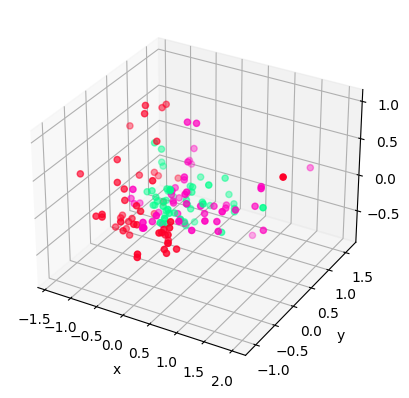

start epoch 2
0.001
Epoch: 2/240 - Loss: 2.82
success rate: 0.59


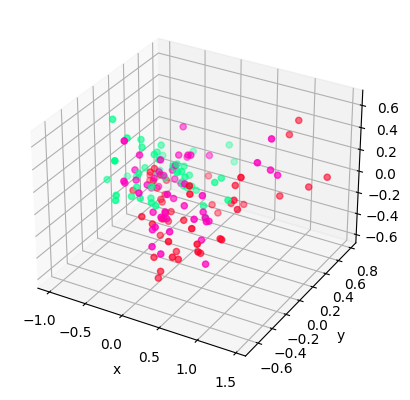

start epoch 3
0.001
Epoch: 3/240 - Loss: 1.43
success rate: 0.57


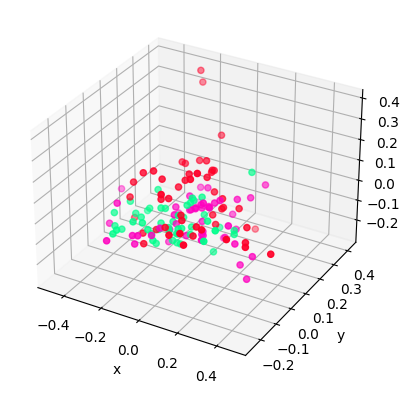

start epoch 4
0.001
Epoch: 4/240 - Loss: 0.95
success rate: 0.56


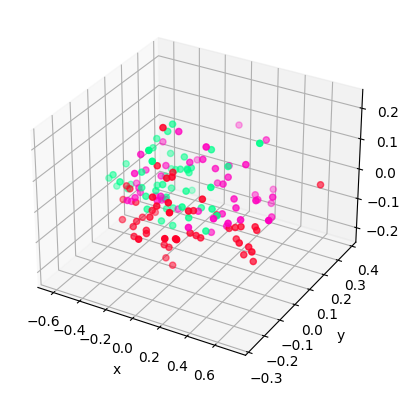

start epoch 5
0.001
Epoch: 5/240 - Loss: 0.76
success rate: 0.64


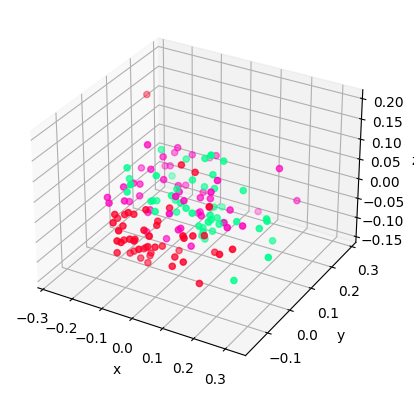

start epoch 6
0.001
Epoch: 6/240 - Loss: 0.66
success rate: 0.58


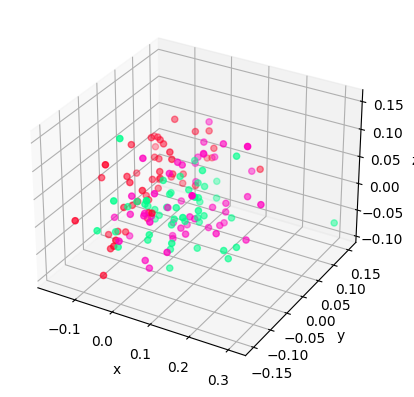

start epoch 7
0.001
Epoch: 7/240 - Loss: 0.59
success rate: 0.63


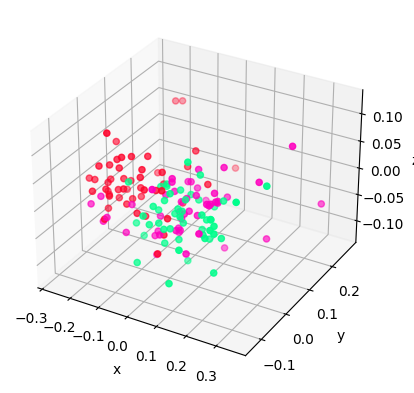

start epoch 8
0.001
Epoch: 8/240 - Loss: 0.57
success rate: 0.69


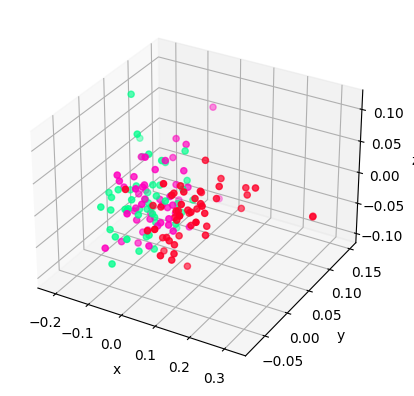

start epoch 9
0.001
Epoch: 9/240 - Loss: 0.57
success rate: 0.68


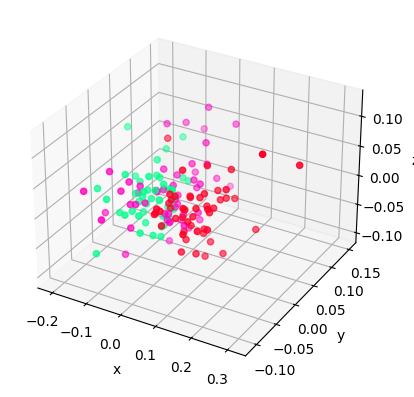

start epoch 10
0.001
Epoch: 10/240 - Loss: 0.55
success rate: 0.66


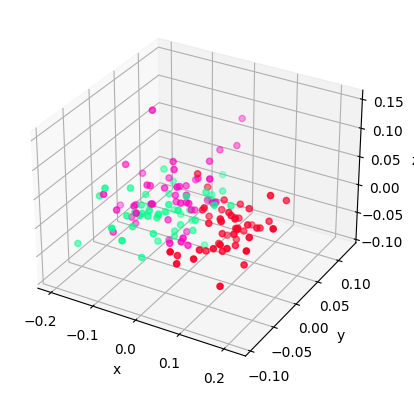

start epoch 11
0.001
Epoch: 11/240 - Loss: 0.55
success rate: 0.63


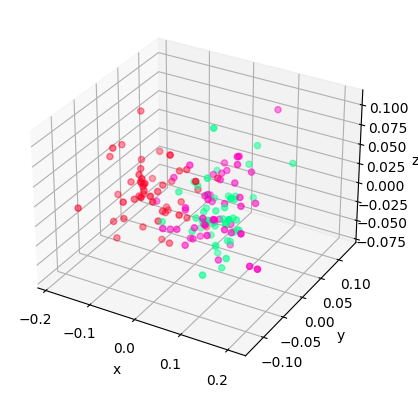

start epoch 12
0.001
Epoch: 12/240 - Loss: 0.54
success rate: 0.70


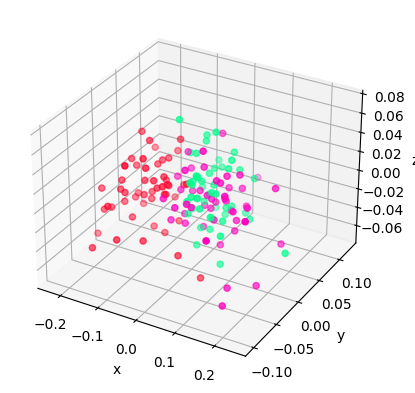

start epoch 13
0.001
Epoch: 13/240 - Loss: 0.54
success rate: 0.76


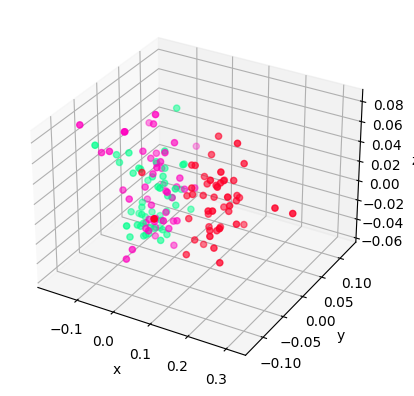

start epoch 14
0.001
Epoch: 14/240 - Loss: 0.53
success rate: 0.78


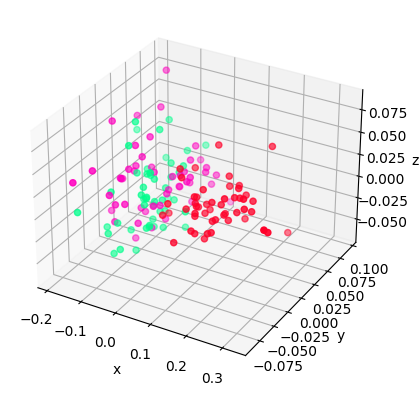

start epoch 15
0.001
Epoch: 15/240 - Loss: 0.53
success rate: 0.73


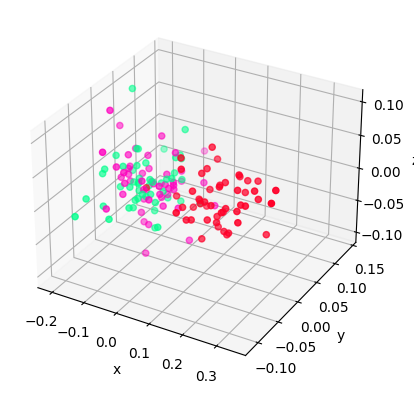

start epoch 16
0.001
Epoch: 16/240 - Loss: 0.53
success rate: 0.76


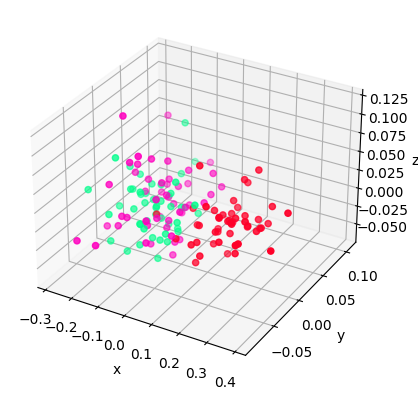

start epoch 17
0.001
Epoch: 17/240 - Loss: 0.52
success rate: 0.78


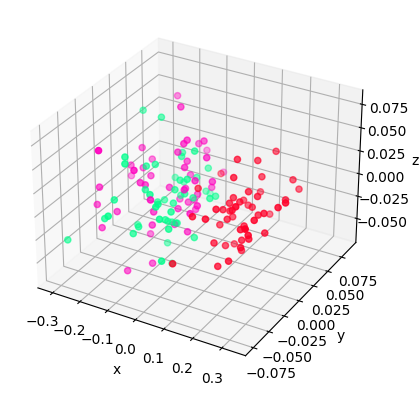

start epoch 18
0.001
Epoch: 18/240 - Loss: 0.52
success rate: 0.80


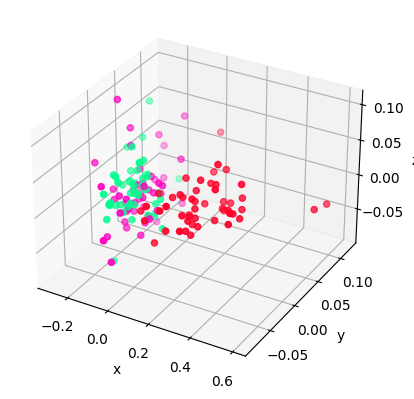

start epoch 19
0.001
Epoch: 19/240 - Loss: 0.51
success rate: 0.78


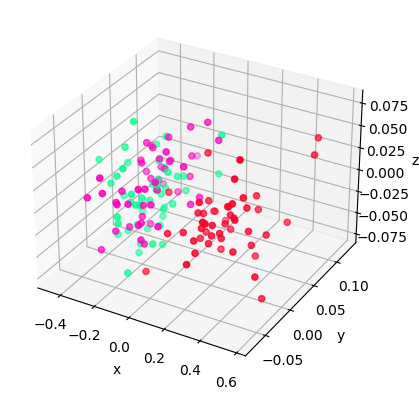

start epoch 20
0.001



KeyboardInterrupt



In [6]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_v2_l
from sklearn.decomposition import PCA



def visualization_3d_(model, data_object):
    pca = PCA(n_components=3)
    batch_size = 2
    n_images = data_object.n_images
    labels = data_object.labels
    embedded_image_list = np.empty([0, 128])
    for i in range(0, int(len(n_images)/batch_size) - 1):
        x = torch.empty((0,3,256,256))
        for j in range(batch_size):
            x = torch.cat([x, n_images[i*batch_size+j].reshape(1,3,256,256)], 0)
        #x = torch.cat([n_images[i].reshape(1,3,256,256), n_images[i].reshape(1,3,256,256)], 0)
        embedded_image = model(x.to(device))
        embedded_image_list = np.append(embedded_image_list, embedded_image.cpu().detach().numpy(), 0)
    principalComponents = pca.fit_transform(embedded_image_list)


    principalDf =pd.DataFrame(data = principalComponents, columns = ['pc1',  'pc2', 'pc3'])
    labelDf = pd.DataFrame(labels)
    principalDf = pd.concat([principalDf,labelDf],axis = 1,join='inner', ignore_index=True)
    principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
    principalDf.columns = ["pc1", "pc2", "pc3", "label"]


    #fig = plt.figure(figsize=(9, 6))
    # Create 3D container
    ax = plt.axes(projection = '3d')
    # Visualize 3D scatter plot
    #mu = random.rand(100,1);
    unique_labels = principalDf["label"].unique()
    name_to_int = {name: i for i, name in enumerate(set(unique_labels))}
    integers = [name_to_int[name] for name in unique_labels]
    labels_colors = [(i - min(integers))/(max(integers) - min(integers))*255 for i in integers]
    labels_colors_dict = dict(zip(unique_labels, labels_colors))
    name_lengths_list = [labels_colors_dict[labels] for labels in principalDf["label"]]
    ax.scatter3D(principalDf["pc1"], principalDf["pc2"], principalDf["pc3"], c = name_lengths_list, cmap='gist_rainbow')
    # Give labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()



class TripletDataSet_(Dataset):
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.train_data_frame = train_data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if Fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"

            self.train_zip_name += '/'
        self.make_data_frame()


        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        if is_train:
            self.train_images_files = self.data_frame.iloc[:, 11].values
            self.train_labels = self.data_frame.iloc[:, 0].values
            self.train_index = self.data_frame.index.values

        self.choose_n_to_visualization(150, 15)

    def make_data_frame(self):
        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = train_data_frame.loc[train_data_frame['new_filename'].isin(image_name_list)]
        data_frame_count = self.data_frame["artist"].value_counts()[:3]
        self.data_frame = self.data_frame[self.data_frame['artist'].isin(data_frame_count[data_frame_count > 15].index) & self.data_frame['artist'].isin(data_frame_count[data_frame_count < 335].index)][:-1]
        self.data_frame = self.data_frame.reset_index(drop=True)


    def choose_n_to_visualization(self, n, num_artist=15):
        data_frame_count = self.data_frame["artist"].value_counts()[:num_artist]
        data_frame_vis = self.data_frame[self.data_frame['artist'].isin(data_frame_count.index)].reset_index(drop=True)
        train_index_vis = data_frame_vis.index.values
        train_labels_vis = data_frame_vis.iloc[:, 0].values

        indices = np.random.choice(train_index_vis, n)
        n_images = torch.empty((0, 3, self.res_size, self.res_size))
        labels = []
        for index in indices:
            file_name = self.train_images_files[index]
            image_data = self.train_archive.open(self.train_zip_name + file_name)
            image = Image.open(image_data)
            label = train_labels_vis[index]

            image = self.toTensor(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]
            image = self.normalize(image)

            n_images = torch.cat([n_images, torch.reshape(image, (1, 3, self.res_size, self.res_size))], 0)
            labels.append(label)
        self.n_images = n_images
        self.labels = labels

    def __len__(self):
        #return 100
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three images per forward sample the 'triplet loss' is relies on
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
            positive_list = np.array(self.train_index[self.train_index!=index])
            positive_list = positive_list[bool_list]

            # case when in sub train group, item don't have a positive partner
            if(len(positive_list) == 0):
                positive_index = index
                raise Exception("No matching image for anchor")
            else:
                positive_index = random.choice(positive_list)

            positive_file_name = self.train_images_files[positive_index]
            positive_image_data = self.train_archive.open(self.train_zip_name + positive_file_name)
            positive_image = Image.open(positive_image_data)

            negative_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
            negative_index = random.choice(negative_list)
            negative_file_name = self.train_images_files[negative_index]
            negative_image_data = self.train_archive.open(self.train_zip_name + negative_file_name)
            negative_image = Image.open(negative_image_data)

            if self.train_labels[positive_index] != self.train_labels[index]:
                print("positive and anchor dont have the same label")

            if self.train_labels[negative_index] == self.train_labels[index]:
                print("negative and anchor have the same label")


            anchor_image = self.toTensor(anchor_image)
            positive_image = self.toTensor(positive_image)
            negative_image = self.toTensor(negative_image)

            # we will feed the model a 3 channel images.
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if positive_image.shape[0] == 1:
                positive_image = torch.cat([positive_image, positive_image, positive_image], 0)
            if positive_image.shape[0] == 4:
                positive_image = positive_image[0:3]

            if negative_image.shape[0] == 1:
                negative_image = torch.cat([negative_image, negative_image, negative_image], 0)
            if negative_image.shape[0] == 4:
                negative_image = negative_image[0:3]

            anchor_image = self.normalize(anchor_image)
            positive_image = self.normalize(positive_image)
            negative_image = self.normalize(negative_image)

            ret_tensor = torch.stack(([anchor_image, positive_image, negative_image]))
            return ret_tensor, anchor_label

        # label = -1, is a signal to not forward the sample
        except Exception as e:
            print(f"could not load a file")
            print(f"Error message: {e}")
            return torch.empty(3, 3, self.res_size, self.res_size), -1
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), -1



class TripletLoss_(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss_, self).__init__()
        self.margin = margin
        self.zero_tensor = torch.tensor([0], requires_grad=False).to(device)

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)


    def predict(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        predictions = distance_positive < distance_negative
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses, predictions


    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(3*distance_positive - distance_negative + self.margin)

        return losses.mean()


#############################
class Network_1(nn.Module):
    def __init__(self, int_dim=3, out_dim=128):
        super(Network_1, self).__init__()
        self.criterion = TripletLoss_()
        self.conv = nn.Sequential(
            nn.Conv2d(int_dim, 32, 6),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(128*28*28, 512),
            nn.PReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x




def test_run_(test_loader, model):
    attempts = 0
    successes = 0
    for step, (inputs, labels) in enumerate(test_loader):
        if ((step + 1) % 300 == 0):
            break
        anchor_img = inputs[:, 0, :, :, :]
        positive_img = inputs[:, 1, :, :, :]
        negative_img = inputs[:, 2, :, :, :]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss, prediction = model.criterion.predict(anchor_out, positive_out, negative_out)
        successes += sum(prediction.cpu()).item()
        attempts += prediction.cpu().shape[0]

    print(f"success rate: {(successes / attempts):0.2f}")
    #input("Press Enter to continue...")




from tqdm.notebook import tqdm
epochs=240
batch_size = 16
model = Network_1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
triplet_loss = TripletLoss_().to(device)
#triplet_loss = nn.TripletMarginLoss(margin=0.5, p=2)

obj = TripletDataSet_("train_1", train_data_frame, Fixed_res=True, res_size=256)
data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
patience = 3
lr_steps = patience
min_loss = 100000000
for epoch in range(epochs):

    print(f"start epoch {epoch+1}")
    #for par in torch.optim.param_groups:
    #    print(torch.optim.param_groups[0]['lr'])
    print(optimizer.param_groups[0]['lr'])
    running_loss = []
    for step, (inputs, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        #if (step+1) % 300 == 0:
        #    break
        if (step+1) % 50 == 0:
            print(step)

        to_continue = False
        for i in range(len(labels)):
            if labels[i] == -1:
                to_continue=True
        if to_continue:
            continue

        anchor_img = inputs[:,0,:,:,:]
        positive_img = inputs[:,1,:,:,:]
        negative_img = inputs[:,2,:,:,:]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)


        loss = triplet_loss(anchor_out, positive_out, negative_out)

        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    current_loss = np.mean(running_loss)
    print("Epoch: {}/{} - Loss: {:.2f}".format(epoch+1, epochs, current_loss))
    test_run_(data_loader, model)
    visualization_3d_(model, obj)

    if current_loss < min_loss:
            min_loss = current_loss
            lr_steps = patience
    else:
        lr_steps = lr_steps - 1
        if lr_steps == 0:
            scheduler.step()
            lr_steps = patience